In [1]:
from IPython import display
import math
from pprint import pprint
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import praw
sns.set(style='darkgrid', context='talk', palette='Dark2')


# Sentiment Analysis on r/CryptoCurrency

As crypto markets tumble, lets use NTLK to detect sentiment on popular subreddit r/CryptoCurrency

Link: https://www.reddit.com/r/CryptoCurrency/

Will be scarpping the "Hottest " posts using praw - *note* we are limited to 1000 posts only

Tutorial Reference: https://www.learndatasci.com/tutorials/sentiment-analysis-reddit-headlines-pythons-nltk/

In [2]:
reddit = praw.Reddit(client_id='######',
                     client_secret='######',
                     user_agent='######')

Query *r/CryptoCurrency* "Hot" posts and store headlines in Set object. 

Output the number of headlines queried (<1000)

In [14]:
headlines = set()

for submission in reddit.subreddit('CryptoCurrency').hot(limit=None):
    headlines.add(submission.title)
    display.clear_output()
    print(len(headlines))

935


Iterate through headlines and apply *polarity_scores* to gauge sentiment

- **neg** : Negative
- **neu** : Neutral
- **pos** : Positive
- **compound** : Aggregate score


In [43]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
results = []

for line in headlines:
    pol_score = sia.polarity_scores(line)
    pol_score['headline'] = line
    results.append(pol_score)

pprint(results[:3], width=100)

[{'compound': 0.0772,
  'headline': 'Name the projects that won’t survive this current bear market/crash/dip/whatever '
              'you want to call it…in your opinion?',
  'neg': 0.0,
  'neu': 0.925,
  'pos': 0.075},
 {'compound': 0.0,
  'headline': 'Can anybody add any advice on Koinly?',
  'neg': 0.0,
  'neu': 1.0,
  'pos': 0.0},
 {'compound': 0.4404,
  'headline': 'NFTs on various L1s and profit potential',
  'neg': 0.0,
  'neu': 0.674,
  'pos': 0.326}]


Convert to DataFrame for EDA

In [28]:
df = pd.DataFrame.from_records(results)
df.describe()

,neg,neu,pos,compound
count,935.000000,935.000000,935.000000,935.000000
mean,0.059436,0.852686,0.087874,0.043589
std,0.119415,0.165016,0.132180,0.327829
min,0.000000,0.222000,0.000000,-0.922900
25%,0.000000,0.748000,0.000000,0.000000
50%,0.000000,0.886000,0.000000,0.000000
75%,0.067500,1.000000,0.164000,0.226300
max,0.767000,1.000000,0.778000,0.918600


Set thresholds on compound score: 

 - Compound > 0.2 $\Rightarrow$ Positive
 - Compound < -0.2 $\Rightarrow$ Negative
 - -0.2 < Compound < 0.2 $\Rightarrow$  Neutral

In [29]:
df['result'] = "Neutral"
df.loc[df['compound'] > 0.2, 'result'] = "Postive"
df.loc[df['compound'] < -0.2, 'result'] = "Negative"
df.head()

,neg,neu,pos,compound,headline,result
0,0.0,0.925,0.075,0.0772,Name the projects that won’t survive this curr...,Neutral
1,0.0,1.000,0.000,0.0000,Can anybody add any advice on Koinly?,Neutral
2,0.0,0.674,0.326,0.4404,NFTs on various L1s and profit potential,Postive
3,0.0,1.000,0.000,0.0000,"On today's episode of ""Buy the Rumor and Sell ...",Neutral
4,0.0,0.737,0.263,0.3612,"Walmart Is Joining The Metaverse, Are We Ready?",Postive


## Sentiment Bar Chart 

Neutral     0.551872
Postive     0.273797
Negative    0.174332
Name: result, dtype: float64


<AxesSubplot:ylabel='result'>

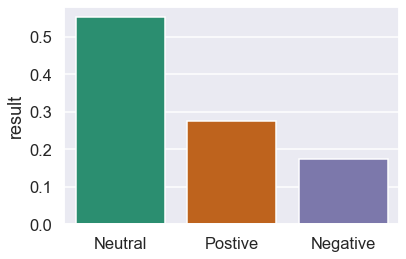

In [40]:
counts = df.result.value_counts(normalize=True)
sns.barplot(x=counts.index, y=counts)